
<div align="center"><img width="275" height="50" src="http://zillow.mediaroom.com/image/Zillow_Wordmark_Blue_RGB.jpg" /> </div> 

<div align="center"> <h1>Cluster Project</h1> 
  <h6> by John Grinstead & David Berchelmann -- April 7, 2021 </h6> </div>
  
  ------------------------------------------------

<div align="center"><img width="800" height="50" src="https://www.zillowstatic.com/s3/homepage/static/Buy_a_home.png" /> </div>



-------

<h1> Welcome! </h1>

The following jupyter notebook will take you through my regression project focusing on Zillow. The dataset comes from a SQL database and can also be accessed via Kaggle.com. 

All of the files and notebooks for this project can be accessed via the github repostiory located at --> https://github.com/davidb-and-john/clustering-project

For ease of reading, many of the large coding sections have been minimzed to allow for a better scrolling experience. If you would like to enlarge a cell to see the data inside, please click on the three dots (<b>...</b>) for the specific cell. To reduce the cell, click the blue box to the left of the selected cell.

----

<h1> Executive Summary </h1>

------

<h4><b>The Problem</b></h4>

- What is driving the errors in the Zestimates?

<h4><b>The Goal</b></h4>

- Use clustering to identify what groups of features are the strongest drivers of log error.

<h4><b>The Process</b></h4>

  * Acquire the Data
  * Prepare 
  * Explore 
  * Model
  * Create Recommendations Based On Findings 
  
<h4><b>The Findings</b></h4>

    
    


-------


<h3><u>Environment Setup</u></h3>

In [1]:
# packages for data analysis & mapping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as dates
import seaborn as sns
import plotly.express as px
from datetime import date 


# Statistical Tests
import scipy.stats as stats
from math import sqrt
from scipy.stats import norm


# modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE 
import sklearn.preprocessing
pd.options.display.float_format = '{:20,.2f}'.format


# address warnings
import warnings
warnings.filterwarnings("ignore")

# acquire, prep, train, & explore functions
from wrangle import get_connection, new_zillow_data, get_zillow_data, clean_zillow, split, seperate_y, scale_data, split_seperate_scale, missing_zero_values_table



<h4> Data Validation </h4>

 - Before the data was brought in through the acquire file, we investigated the set in SQL. Below are a few of our findings:
     - Some properties were labeled as 'single family residential' but had a unit count of more than 1
     - There were a number of properties that lacked location info (zip, lat, long, fips), these will be dropped in prep
     - Bedrooms and Bathrooms both have rows that have a value of 0. These were filled filled with the median count for each feature.
     - There were entries that had multiple transaction dates. To account for this, we filtered for the latest max date. We also did this for log error.

---
<h3><u>Acquire the Data</u></h3>

----

In [2]:
df = pd.read_csv("zillowcluster_df.csv")
print(f'Our original dataframe is coming in with {df.shape[0]} rows and {df.shape[1]} columns.')

Our original dataframe is coming in with 77413 rows and 68 columns.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77413 entries, 0 to 77412
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    77413 non-null  int64  
 1   typeconstructiontypeid        222 non-null    float64
 2   storytypeid                   50 non-null     float64
 3   heatingorsystemtypeid         49439 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      206 non-null    float64
 6   airconditioningtypeid         24953 non-null  float64
 7   parcelid                      77413 non-null  int64  
 8   id                            77413 non-null  int64  
 9   basementsqft                  50 non-null     float64
 10  bathroomcnt                   77380 non-null  float64
 11  bedroomcnt                    77380 non-null  float64
 12  buildingqualitytypeid         49671 non-null  float64
 13  c

In [4]:
df.describe()

,Unnamed: 0,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,"77,413.00",222.00,50.00,"49,439.00",15.00,206.00,"24,953.00","77,413.00","77,413.00",50.00,...,"17,560.00",172.00,"77,268.00","77,379.00","77,380.00","77,378.00","77,375.00","2,886.00","77,136.00","77,413.00"
mean,"38,706.00",6.04,7.00,3.92,3.93,7.39,1.81,"13,006,697.32","1,495,761.15",679.72,...,1.43,1.00,"189,315.98","490,137.46","2,016.00","301,096.94","5,995.57",14.09,"60,496,735,236,339.62",0.02
std,"22,347.35",0.56,0.00,3.59,0.26,2.73,2.97,"3,480,712.14","861,270.67",689.70,...,0.54,0.00,"230,088.56","653,447.67",0.00,"492,599.03","7,622.89",2.19,"1,535,251,869,244.56",0.17
min,0.00,4.00,7.00,1.00,3.00,2.00,1.00,"10,711,855.00",349.00,38.00,...,1.00,1.00,44.00,"1,000.00","2,016.00",161.00,19.92,3.00,"60,371,011,101,000.00",-4.66
25%,"19,353.00",6.00,7.00,2.00,4.00,7.00,1.00,"11,538,336.00","752,413.00",273.00,...,1.00,1.00,"84,265.00","207,000.00","2,016.00","85,504.00","2,715.59",14.00,"60,373,109,005,001.75",-0.02
50%,"38,706.00",6.00,7.00,2.00,4.00,7.00,1.00,"12,530,673.00","1,498,471.00",515.00,...,1.00,1.00,"136,499.50","358,976.00","2,016.00","203,383.50","4,450.72",15.00,"60,376,032,003,008.00",0.01
75%,"58,059.00",6.00,7.00,7.00,4.00,7.00,1.00,"14,211,486.00","2,241,718.00",796.50,...,2.00,1.00,"218,787.50","569,003.00","2,016.00","366,802.25","6,927.80",15.00,"60,590,423,251,008.00",0.04
max,"77,412.00",13.00,7.00,24.00,4.00,21.00,13.00,"167,689,317.00","2,985,182.00","3,560.00",...,6.00,1.00,"11,421,790.00","49,061,236.00","2,016.00","48,952,198.00","586,639.30",99.00,"483,030,105,084,015.00",5.26


In [5]:
df.isna().sum()

Unnamed: 0                          0
typeconstructiontypeid          77191
storytypeid                     77363
heatingorsystemtypeid           27974
buildingclasstypeid             77398
architecturalstyletypeid        77207
airconditioningtypeid           52460
parcelid                            0
id                                  0
basementsqft                    77363
bathroomcnt                        33
bedroomcnt                         33
buildingqualitytypeid           27742
calculatedbathnbr                 642
decktypeid                      76799
finishedfloor1squarefeet        71390
calculatedfinishedsquarefeet      229
finishedsquarefeet12             3665
finishedsquarefeet13            77372
finishedsquarefeet15            74404
finishedsquarefeet50            71390
finishedsquarefeet6             77027
fips                               33
fireplacecnt                    69137
fullbathcnt                       642
garagecarcnt                    51939
garagetotals

In [6]:
missing_zero_values_table(df)

Your selected dataframe has 68 columns and 77413 Rows.
There are 63 columns that have NULL values.


,Zero Values,null_count,% of Total Values,Total Zeroes + Null Values,% Total Zero + Null Values,Data Type
buildingclasstypeid,0,77398,100.00,77398,100.00,float64
buildingclassdesc,0,77398,100.00,77398,100.00,object
finishedsquarefeet13,0,77372,99.90,77372,99.90,float64
storytypeid,0,77363,99.90,77363,99.90,float64
storydesc,0,77363,99.90,77363,99.90,object
basementsqft,0,77363,99.90,77363,99.90,float64
yardbuildingsqft26,0,77343,99.90,77343,99.90,float64
fireplaceflag,0,77241,99.80,77241,99.80,float64
architecturalstyletypeid,0,77207,99.70,77207,99.70,float64
architecturalstyledesc,0,77207,99.70,77207,99.70,object


-----
<h3><u> Initial Thoughts</u> </h3>

- This data set is extrememly messy and is littered with nulls and zero values. With so many nulls, each category will be reviewed to determine if there is a way to fill those nulls with values or if they will need to be deleted all togther.

- We will look at the missing values table again in the prep stage to see how our dataset was cleaned up.

- There is redundancy in columns (like those dealing with square footage) that will be dealt with.

----

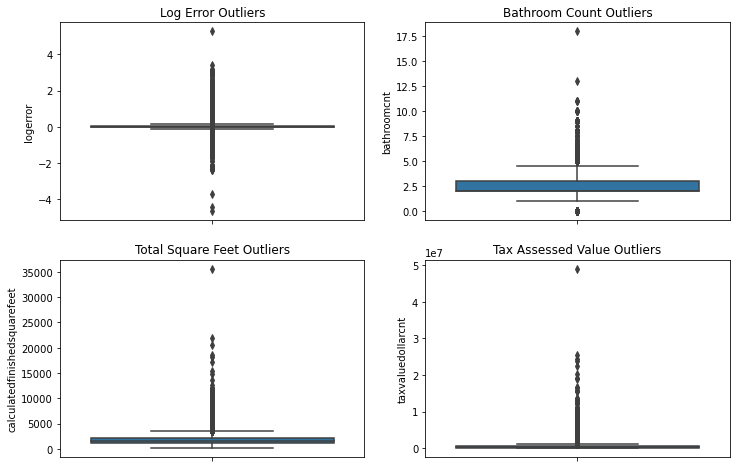

In [7]:
# visualize outliers using boxplots:

plt.figure(figsize = (12,8))
plt.subplot(221)
sns.boxplot(y = df.logerror)
plt.title('Log Error Outliers')

plt.subplot(222)
sns.boxplot(y = df.bathroomcnt)
plt.title('Bathroom Count Outliers')


plt.subplot(223)
sns.boxplot(y = df.calculatedfinishedsquarefeet)
plt.title('Total Square Feet Outliers')


plt.subplot(224)
sns.boxplot(y = df.taxvaluedollarcnt)
plt.title('Tax Assessed Value Outliers')

plt.show()

<h3><u>Boxplot Takeaways</u></h3>

- There are some major outliers that will need to be dealt with in prep. 
- Bathroom outliers may be dealt with by taking care of finished square feet first. 
- Log error appears to have outliers (both positive and negative) that will need to be handled since clustering with K-Means is extremely sensitve to outliers.

----

<h3>Clean/Prep the Data</h3>

----

In [8]:
df = clean_zillow(df)

------

<h5><i>Before we get into what prep was done to the data, let's take a look at our missing values table. If you go back up to cell 22, you will see that this data set was littered with null values and zeros. Let's take another peak.</i></h5>

-----

In [9]:
missing_zero_values_table(df)

Your selected dataframe has 30 columns and 59959 Rows.
There are 0 columns that have NULL values.


,Zero Values,null_count,% of Total Values,Total Zeroes + Null Values,% Total Zero + Null Values,Data Type
heatingorsystemtypeid,0,0,0.00,0,0.00,float64
airconditioningtypeid,0,0,0.00,0,0.00,float64
orange_county,41142,0,0.00,41142,68.60,uint8
la_county,24379,0,0.00,24379,40.70,uint8
bath_bed_ratio,0,0,0.00,0,0.00,float64
sqft_bin,2277,0,0.00,2277,3.80,float64
acres_bin,7276,0,0.00,7276,12.10,float64
acres,0,0,0.00,0,0.00,float64
taxrate,0,0,0.00,0,0.00,float64
baths_per_sqft,42,0,0.00,42,0.10,float64


---

<h5><i>As you can see, we went from 68 columns and 77,413 rows down to 30 columns and 63,987 rows</i></h5>

---

<h3>Prep Work Done To Data</h3>

----

- Identify properties that do not qualify as single family homes
    
    
- Delete properties that do not qualify as single family homes
    
    
- Create new column (age_of_home)
    today = pd.to_datetime('today')
    df['age_of_home'] = today.year - df['yearbuilt']
    
               
- Remove NaNs from finished square feet
   
    
- Replace '0' bathrooms with the median which is 2
    
  
- Replace '0' bedrooms with the median which is 3
    

    
- Remove NaNs from tax amount
    
  
- Remove NaNs from year_built
    
- Remove NaNs from tax value dollar count
  
- Remove decimal from latitude and longitude
   
- Convert latitude and longitude to positonal data points using lambda funtion (i.e. putting a decimal in the correct place)
   
- Remove properties with a unit count greater than 1
    
- Delete properties that do not qualify as single family homes
    
- Drop unitcnt column
    
- Remove properties with a tax value greater than or equal to 1.68 million dollars and sqfootage greater than 3500 (these are outliers causing issues)
    
- Convert age_of_home column from float to an integer (this removes the decimal point)
  
- Create bathrooms per sqft
    ``` df['bath_pers_qft'] = df['bathroomcnt'] / df['calculatedfinishedsquarefeet'] ```
    
   
   
- Set parcelid as the index
   
    
- drop un-needed columns
  - ```df.drop('landuse_id', axis=1, inplace=True)```
  -  ```df.drop('landuse_desc', axis=1, inplace=True)```
  -  ```df.drop('last_sold_date', axis=1, inplace=True)```
  -  ```df.drop('tax_assess_yr', axis=1, inplace=True)```
    

- convert columns to object
    

  -  ```df['fips'] = df['fips'].astype(object)```
  -  ```df['year_built'] = df['year_built'].astype(object)```

<h5>Let's take one more look at those outliers now that we've cleaned the data</h5>

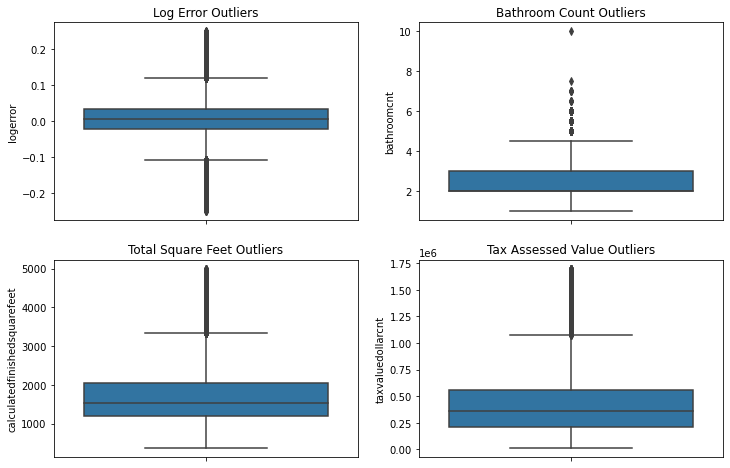

In [10]:
plt.figure(figsize = (12,8))
plt.subplot(221)
sns.boxplot(y = df.logerror)
plt.title('Log Error Outliers')

plt.subplot(222)
sns.boxplot(y = df.bathroomcnt)
plt.title('Bathroom Count Outliers')


plt.subplot(223)
sns.boxplot(y = df.calculatedfinishedsquarefeet)
plt.title('Total Square Feet Outliers')


plt.subplot(224)
sns.boxplot(y = df.taxvaluedollarcnt)
plt.title('Tax Assessed Value Outliers')

plt.show()

<h3><u>Data Dictionary</u></h3>



- Below is our most current data dictionary.



|   Feature      |  Data Type   | Description    |
| :------------- | :----------: | -----------: |
|  parcelid | float64  | Unique parcel identifier    |
| heatingorsystemtypeid    | float64| Identifier for heating type|
| airconditioningtypeid  | float64 | Identifier for ac type|
| bathroomcnt | float64 |number of bathrooms in property|
|  bedroomcnt    | float64  | number of bedrooms in property   |
| calculatedfinishedsquarefeet   | float64 | total livable square footage|
| fips    | object| Federal Information Processing Code (county code)|
| latitude | float64 | geographic coordinate that specifies the north–south position|
|  longitude  | float64   | geographic coordinate that specifies the east-west position |
| poolcnt    | float64 | has pool = 1, no pool = 0|
| roomcnt   | float64 | count of rooms in property|
| yearbuilt   | float64 | year home was built |
|  fireplaceflag  | int64   | Has fireplace = 1, no fireplace = 0     |
| taxvaluedollarcnt   | float64 | The most recent year property taxes were assessed|
| taxamount   | float64 | ad valorem tax on the value of a property.|
| logerror  | float64 | age of home as of today's date in years|
| transactiondate     | datetime64[ns] | date property was last sold|
| airconditioningdesc   | object | description of AC type|
| heatingorsystemdesc  | object| description of Heating type|
|age_of_home  | float64   | Current date - Year Built in years    |
|  age_bin  | float64 | year home was built|
|  baths_per_sqft | float64 | numbers of baths per sqft|
|  taxrate   | float64 | This is property tax / tax_assessed_value |
|  acres   | float64   | lot square footage / 43,560     |
|  acres_bin   | float64 | properties binned into groups by acreage amounts|
|  sqft_bin | float64 | properties binned into groups by square footage amounts|
|  bath_bed_ratio  | float64 | bathroomcnt/bedroomcnt|
|   la_county   | uint8  | property in LA = 1, not in LA = 0|
|  orange_county  | uint8  | property in Orange = 1, not in Orange = 0|
| ventura_county  | uint8 | property in Ventura = 1, not in ventura = 0|
















-----

<h3> Explore the Data </h3>

-----

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59959 entries, 10711855 to 167688532
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   heatingorsystemtypeid         59959 non-null  float64       
 1   airconditioningtypeid         59959 non-null  float64       
 2   bathroomcnt                   59959 non-null  float64       
 3   bedroomcnt                    59959 non-null  float64       
 4   calculatedfinishedsquarefeet  59959 non-null  float64       
 5   fips                          59959 non-null  object        
 6   latitude                      59959 non-null  float64       
 7   longitude                     59959 non-null  float64       
 8   lotsizesquarefeet             59959 non-null  float64       
 9   poolcnt                       59959 non-null  float64       
 10  roomcnt                       59959 non-null  float64       
 11  yearbuilt        

In [12]:
df.describe()

,heatingorsystemtypeid,airconditioningtypeid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,poolcnt,roomcnt,...,age_bin,baths_per_sqft,taxrate,acres,acres_bin,sqft_bin,bath_bed_ratio,la_county,orange_county,ventura_county
count,"59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00",...,"59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00","59,959.00"
mean,2.96,4.19,2.22,3.06,"1,710.43",33.99,-118.18,"8,184.29",0.18,1.74,...,0.38,0.00,1.28,0.19,0.17,0.36,0.76,0.59,0.31,0.09
std,3.41,2.24,0.83,0.95,729.38,0.27,0.38,"5,274.59",0.38,2.97,...,0.15,0.00,0.22,0.12,0.10,0.18,0.27,0.49,0.46,0.29
min,1.00,1.00,1.00,1.00,360.00,33.34,-119.48,236.00,0.00,0.00,...,0.00,0.00,0.21,0.01,0.00,0.00,0.20,0.00,0.00,0.00
25%,1.00,1.00,2.00,2.00,"1,199.00",33.79,-118.40,"5,724.00",0.00,0.00,...,0.27,0.00,1.16,0.13,0.10,0.20,0.50,0.00,0.00,0.00
50%,2.00,5.00,2.00,3.00,"1,538.00",33.99,-118.14,"7,241.00",0.00,0.00,...,0.40,0.00,1.22,0.17,0.20,0.40,0.67,1.00,0.00,0.00
75%,2.00,5.00,3.00,4.00,"2,053.00",34.17,-117.90,"8,297.00",0.00,4.00,...,0.47,0.00,1.34,0.19,0.20,0.50,1.00,1.00,1.00,0.00
max,24.00,13.00,10.00,10.00,"4,999.00",34.72,-117.55,"36,805.00",1.00,12.00,...,0.93,0.01,2.30,0.84,0.40,0.80,7.50,1.00,1.00,1.00


-----

<h3> Model the Data </h3>

-----

-------

<h3>Conclusions & Thoughts Moving Forward</h3>

-----